In [1]:
import json
import matplotlib.pyplot as plt
import torch
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan']
# name_list = ['tst-rl-gpt2-xl.json', 'tst-dpo-gpt2-xl.json', 'tst-dpo-multi-gpt2-xl.json']
# save_dir = '/hpcgpfs01/scratch/gzhao/rl-prompt/examples/text-style-transfer/outputs/2024-03-22'
# name_list = ['outputs/2024-03-27/15-30-10tst-ipo-gpt2-xl', 
#              'outputs/2024-03-27/15-29-39tst-rl-gpt2-xl', 
#              'outputs/2024-03-27/15-29-00tst-ipo-multi-gpt2-xl'
#              ]
save_dir = '/hpcgpfs01/scratch/gzhao/rl-prompt/examples/text-style-transfer'

def find_pareto_front(samples):
    """
    Find the Pareto front of given sample points.
    
    :param samples: Torch tensor of size N*2 containing sample points (N samples, 2 objectives).
    :return: Pareto front as a torch tensor.
    """
    pareto_front = []
    dominated_by = torch.zeros(samples.size(0), dtype=torch.bool)
    
    for idx, point1 in enumerate(samples):
        if not dominated_by[idx]:
            pareto_front.append(idx)
            for j, point2 in enumerate(samples):
                if idx != j:
                    if torch.all(point1 >= point2):
                        dominated_by[j] = True
                    elif torch.all(point1 <= point2):
                        dominated_by[idx] = True
                        pareto_front.remove(idx)
                        break
    pareto_front_tensor = samples[pareto_front]
    
    return pareto_front_tensor

def calculate_dominating_volume(pareto_front, ref_point):
    """
    Calculate the dominating volume of the Pareto front with respect to a reference point.
    
    :param pareto_front: Torch tensor of size N*2 containing points in the Pareto front (N points, 2 objectives).
    :param ref_point: Torch tensor of size 2 representing the reference point.
    :return: Dominating volume of the Pareto front.
    """
    # Sort Pareto front based on the first objective (ascending order)
    sorted_pareto_front = pareto_front[pareto_front[:, 0].argsort()]
    
    # Initialize dominating volume
    dominating_volume = 0.0
    
    # Initialize the upper left corner of the rectangle
    upper_left_corner = ref_point.clone()
    
    # Iterate through sorted Pareto front
    for point in sorted_pareto_front:
        # Calculate the width and height of the rectangle
        width = point[0] - upper_left_corner[0]  
        height = point[1] - upper_left_corner[1]  
        
        # Update dominating volume by adding the area of the rectangle
        dominating_volume += width * height
        
        # Update the upper left corner for the next rectangle
        upper_left_corner[0] = point[0]
    
    return dominating_volume

In [2]:
name_list = [
             'outputs/2024-03-27/15-29-39tst-rl-gpt2-xl-64', 
             'outputs/2024-03-27/15-30-10tst-ipo-gpt2-xl-64', 
             'outputs/2024-03-18/12-54-12tst-ipo-multi-gpt2-xl-64',
             'outputs/2024-03-30/12-41-56tst-ipo-multi-prob_diff-gpt2-xl', 
             'outputs/2024-03-30/12-42-07tst-ipo-multi-gpt2-xl-0.1lr', 
             "outputs/2024-04-04/04-07-46tst-ipo-multi-prob_diff-gpt2-xl-0.1", 
             "outputs/2024-04-04/05-24-39tst-ipo-single-gpt2-xl-0.1lr", 
             "outputs/2024-04-16/13-23-28tst-ipo-multi-prob_diff-gpt2-xl-0.1",
             "outputs/2024-04-18/20-11-52tst-ipo-multi-prob_diff-gpt2-xl-e0.1",
             "outputs/2024-04-18/21-18-38tst-ipo-multi-prob_diff-gpt2-xl-e0.5",
             "outputs/2024-04-26/15-41-51tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tus100", 
            "outputs/2024-04-26/15-43-03tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tus200", 
            "outputs/2024-04-26/15-43-05tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tus500",
            "outputs/2024-04-30/22-29-23tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tus200", 
            "outputs/2024-05-18/23-40-11tst-ipo-multi-gpt2-xl-0.1lr", 
            "outputs/2024-05-19/00-00-48tst-ipo-multi-gpt2-xl-0.1lr",
             ]

"outputs/2024-04-16/13-23-28tst-ipo-multi-prob_diff-gpt2-xl-0.1" #12000 result

'outputs/2024-04-16/13-23-28tst-ipo-multi-prob_diff-gpt2-xl-0.1'

In [23]:
name_list = [
    'outputs/2024-03-27/15-29-39tst-rl-gpt2-xl-64',
            'outputs/2024-03-30/12-42-07tst-ipo-multi-gpt2-xl-0.1lr', 
             "outputs/2024-04-04/05-24-39tst-ipo-single-gpt2-xl-0.1lr", 
             "outputs/2024-04-18/20-11-52tst-ipo-multi-prob_diff-gpt2-xl-e0.1",
              "outputs/2024-04-26/15-41-51tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tus100", 
            "outputs/2024-04-26/15-43-03tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tus200", 
            "outputs/2024-04-26/15-43-05tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tus500",
            "outputs/2024-05-18/23-40-11tst-ipo-multi-gpt2-xl-0.1lr", #dominant only IPO
            "outputs/2024-05-19/00-00-48tst-ipo-multi-gpt2-xl-0.1lr", #rlprompt wrong
             ]

In [42]:
#paper draw
name_list = [
    "outputs/2024-05-19/16-12-30tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tussingle_dpo", #reward dpo 
    "outputs/2024-05-19/15-24-23tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tussingle_ipo", #reward ipo
    "outputs/2024-05-18/23-40-11tst-ipo-multi-gpt2-xl-0.1lr",  #dominant only IPO
    "outputs/2024-05-19/16-13-29tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tusmulti_nond_dpo", #dominant only DPO
    "outputs/2024-04-26/15-43-03tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tus200", #paretoprompt IPO
    "outputs/2024-05-19/14-32-39tst-dpo-multi-prdif-gpt2-xl-0.1lr" , #PP dpo
    "outputs/2024-05-19/14-34-04tst-dpo-multi-noND-gpt2-xl-0.1lr", 
]
# result_dict
# first layer names are run_names
# under each run_name are iteration names
# third layer names: content, style, dominating_volume
import os
from collections import defaultdict
result_dict = defaultdict(dict)
for j, name in enumerate(name_list):
    file_name = os.path.join(save_dir, name) + '.json'
    with open(file_name) as f:
        performance = json.load(f)
    for key in performance.keys():
        content = torch.tensor(performance[key]['content'])
        style = torch.tensor(performance[key]['style'])
        samples = torch.stack((content, style), dim=1)
        pareto_front_tensor = find_pareto_front(samples)

        # Reference point (torch tensor of size 2)
        reference_point = torch.tensor([.0, .0])

        # Calculate dominating volume
        dominating_volume = calculate_dominating_volume(pareto_front_tensor, reference_point)
        
        performance[key]['dominating_volume']=dominating_volume
        performance[key]['content'] = content
        performance[key]['style'] = style
    result_dict[name] = performance

In [43]:
result_dict[name_list[-1]].keys()

dict_keys(['1000', '2000', '3000', '4000', '5000', '6000'])

KeyError: '600'

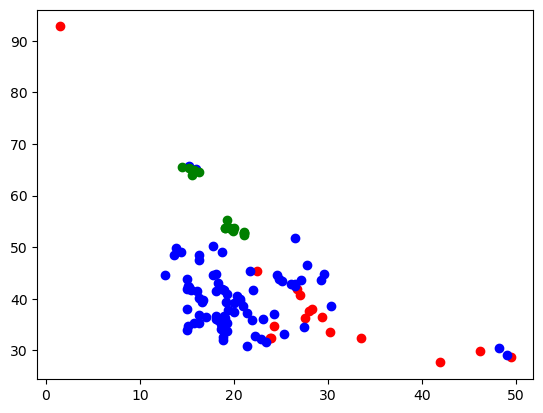

In [28]:
for j, name in enumerate(name_list):
    for i in list(['200', '600', "6400"]):
        
        content = result_dict[name][i]['content']
        style = result_dict[name][i]['style']
        
        # name = name.split('/')[-1][8:]+i
        plt.scatter(content, style, color=colors[j], label=name+i)
        j+=1
    # for t, (content, style) in enumerate(zip(performance[i]['content'], performance[i]['style'])):
    #     plt.scatter(content, style, color=colors[j], label=name if t==0 else None)
plt.scatter(50, 45, color='k')
plt.xlabel('content score')
plt.ylabel('sentiment score')
plt.legend()
plt.show()

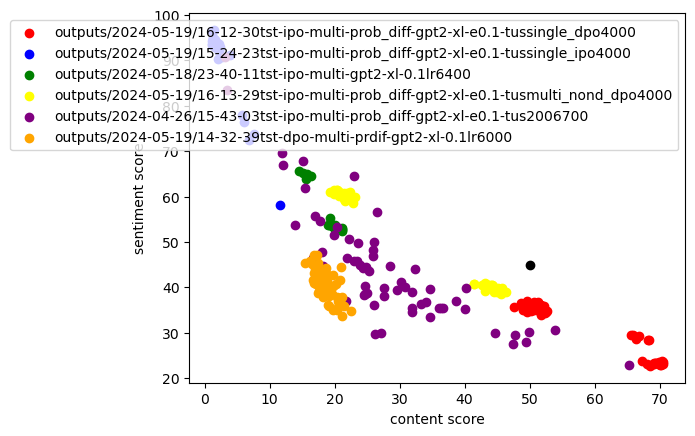

In [41]:
for j, name in enumerate(name_list):
    for i in list(result_dict[name].keys())[-1:]:
        
        content = result_dict[name][i]['content']
        style = result_dict[name][i]['style']
        
        # name = name.split('/')[-1][8:]+i
        plt.scatter(content, style, color=colors[j], label=name+i)
        j+=1
    # for t, (content, style) in enumerate(zip(performance[i]['content'], performance[i]['style'])):
    #     plt.scatter(content, style, color=colors[j], label=name if t==0 else None)
plt.scatter(50, 45, color='k')
plt.xlabel('content score')
plt.ylabel('sentiment score')
plt.legend()
plt.show()

IndexError: list index out of range

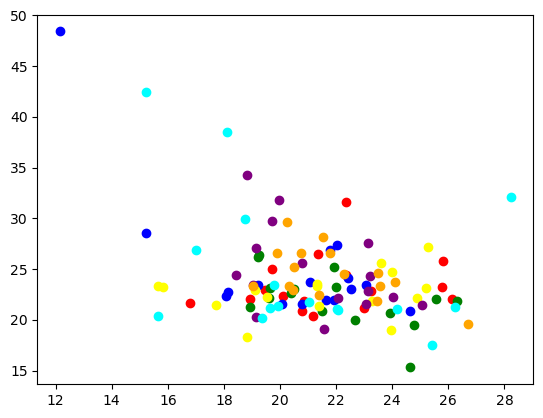

In [8]:
for j, name in enumerate(name_list):
    for i in list(result_dict[name].keys()):
        
        content = result_dict[name][i]['content']
        style = result_dict[name][i]['style']
        
        # name = name.split('/')[-1][8:]+i
        plt.scatter(content, style, color=colors[j], label=name+i)
        j+=1
    # for t, (content, style) in enumerate(zip(performance[i]['content'], performance[i]['style'])):
    #     plt.scatter(content, style, color=colors[j], label=name if t==0 else None)
plt.xlabel('content score')
plt.ylabel('sentiment score')
plt.legend()
plt.show()

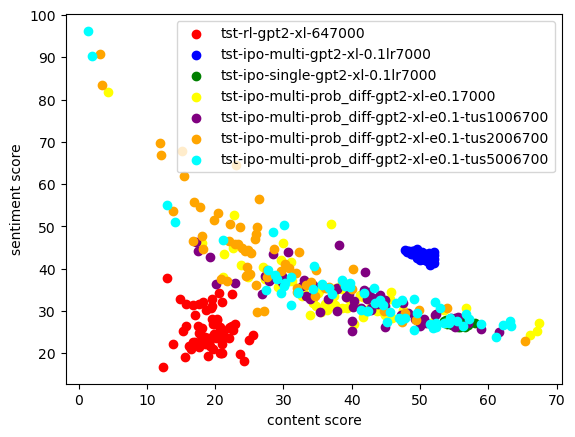

In [25]:
for j, name in enumerate(name_list):
    i = list(result_dict[name].keys())[-1]
    content = result_dict[name][i]['content']
    style = result_dict[name][i]['style']
    
    name = name.split('/')[-1][8:]+i
    plt.scatter(content, style, color=colors[j], label=name)
    # for t, (content, style) in enumerate(zip(performance[i]['content'], performance[i]['style'])):
    #     plt.scatter(content, style, color=colors[j], label=name if t==0 else None)
plt.xlabel('content score')
plt.ylabel('sentiment score')
plt.legend()
plt.show()

Text(0.5, 0, 'Training Iterations')

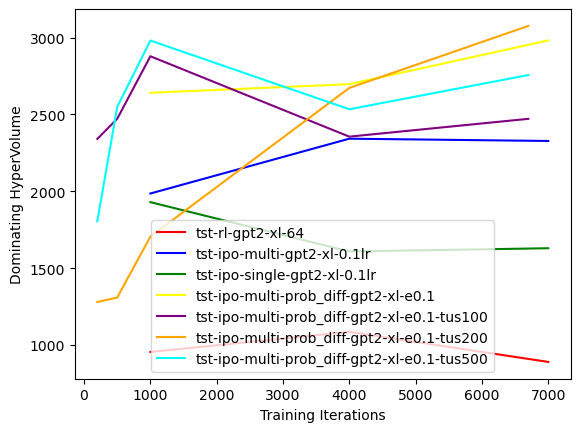

In [28]:
for j, name in enumerate(name_list):
    linex = []
    liney = []
    for i in result_dict[name].keys():
        linex.append(int(i))
        liney.append(result_dict[name][i]['dominating_volume'])
    name = name.split('/')[-1][8:]
    plt.plot(linex, liney, color=colors[j], label=name)
        
plt.legend()
plt.ylabel("Dominating HyperVolume")
plt.xlabel("Training Iterations")

In [7]:
import torch

def find_pareto_front(samples):
    """
    Find the Pareto front of given sample points.
    
    :param samples: Torch tensor of size N*2 containing sample points (N samples, 2 objectives).
    :return: Pareto front as a torch tensor.
    """
    pareto_front = []
    dominated_by = torch.zeros(samples.size(0), dtype=torch.bool)
    
    for idx, point1 in enumerate(samples):
        if not dominated_by[idx]:
            pareto_front.append(idx)
            for j, point2 in enumerate(samples):
                if idx != j:
                    if torch.all(point1 >= point2):
                        dominated_by[j] = True
                    elif torch.all(point1 <= point2):
                        dominated_by[idx] = True
                        pareto_front.remove(idx)
                        break
    pareto_front_tensor = samples[pareto_front]
    
    return pareto_front_tensor

def calculate_dominating_volume(pareto_front, ref_point):
    """
    Calculate the dominating volume of the Pareto front with respect to a reference point.
    
    :param pareto_front: Torch tensor of size N*2 containing points in the Pareto front (N points, 2 objectives).
    :param ref_point: Torch tensor of size 2 representing the reference point.
    :return: Dominating volume of the Pareto front.
    """
    # Sort Pareto front based on the first objective (ascending order)
    sorted_pareto_front = pareto_front[pareto_front[:, 0].argsort()]
    
    # Initialize dominating volume
    dominating_volume = 0.0
    
    # Initialize the upper left corner of the rectangle
    upper_left_corner = ref_point.clone()
    
    # Iterate through sorted Pareto front
    for point in sorted_pareto_front:
        # Calculate the width and height of the rectangle
        width = point[0] - upper_left_corner[0]  
        height = point[1] - upper_left_corner[1]  
        
        # Update dominating volume by adding the area of the rectangle
        dominating_volume += width * height
        
        # Update the upper left corner for the next rectangle
        upper_left_corner[0] = point[0]
    
    return dominating_volume

# Example sample points (torch tensor of size N*2)
samples = torch.tensor([[1, 2], [2, 1], [1.2, 1.7], [1.5, 1.5]])

# Find Pareto front
pareto_front_tensor = find_pareto_front(samples)

# Reference point (torch tensor of size 2)
reference_point = torch.tensor([.0, .0])

# Calculate dominating volume
dominating_volume = calculate_dominating_volume(pareto_front_tensor, reference_point)

# Print dominating volume
print("Dominating Volume:", dominating_volume)


Dominating Volume: tensor(3.2900)
